## Face Recognition (from Python Data Science Handbook by Jake VanderPlas)

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70)#, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("h, w: %d" % h , w)
print(lfw_people.images.shape)

Total dataset size:
n_samples: 1288
n_features: 2914
n_classes: 7
h, w: 62 47
(1288, 62, 47)


Let's plot a few of these faces to see what we're working with:

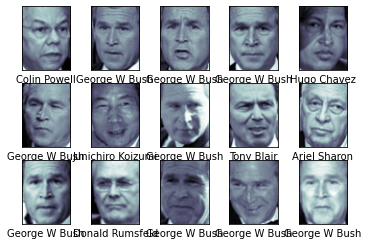

In [3]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])
    
# ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [7]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale, StandardScaler
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'svc__C': 5, 'svc__gamma': 0.001}
0.828893332683022


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [11]:
model = grid.best_estimator_
yfit = model.predict(X_test)

Let's take a look at a few of the test images along with their predicted values:

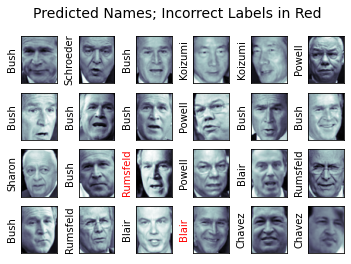

In [14]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair and Rumsfield).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

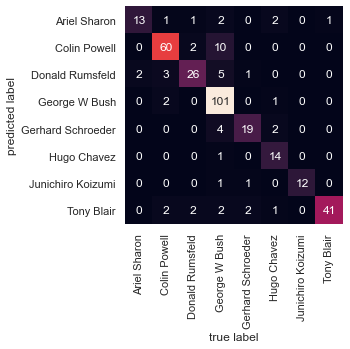

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.